In [1]:
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython
from IPython.display import display
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import time

# import models
# import train_lstm

In [ ]:
# import importlib
# importlib.reload(train_lstm)
# importlib.reload(models)

## Define Model

In [5]:
seed = 1289719
series_min_len = 144 #12hrs
pred_horizon = 12 # 1hr
input_size = series_min_len - pred_horizon
output_size = pred_horizon
import math
dataset_path = '../timeseries_0-patients_step-1_len-x.pkl'

# group_id = 2
# dataset_path = "timeseries_"+str(group_id)+"-patients_step-1.pkl"

In [7]:
epochs = 20
batch_size = 128
learning_rate = 0.001
save_every = 1
test_every = save_every

epoch_start = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Training on GPU!')
else:
    print('No GPU available, training on CPU; consider making n_epochs very small.')

# lstm_trainer = train_lstm.LSTM_Trainer(seed, device)

# heurisitic = models.Heuristic(1, 1).to(device)
loss_func = nn.MSELoss()

No GPU available, training on CPU; consider making n_epochs very small.


## Copy Last

In [ ]:
# #load test set
# lstm_trainer.load_test(dataset_path, 1, input_size, pred_horizon, 0)
# data_loader = lstm_trainer.test_loader

In [ ]:
# num_batches = len(data_loader)
# print(num_batches)
# total_loss = 0


# start = time.time()
# esod = 0
# for X, y in data_loader:
#     last = X[0][-1]
#     prediction_full = last.repeat(1,pred_horizon)
#     #MSE
#     total_loss += loss_func(prediction_full, y).item()

#     #ESOD
#     # esod_pred = 0
#     # esod_y = 0
#     # preds = prediction_full.cpu().detach().numpy()[0]
#     # y_t = y.cpu().detach().numpy()[0]
#     # for j in range(2, len(preds)):
#     #     esod_pred += math.pow((preds[j] - 2*preds[j-1] + preds[j-2]), 2)
#     #     esod_y += math.pow((y_t[j] - 2*y_t[j-1] + y_t[j-2]), 2)
#     # if (esod_y != 0):
#     #     esod += esod_pred / esod_y
#     # break

# end = time.time()

# avg_loss = total_loss / num_batches
# print(f"Test loss: {avg_loss}")
# print("avg ESOD:", esod/num_batches)

# print("Time: ", end-start)


## Linear Regression

In [9]:
import pickle
[_, X_test, _, y_test] = pickle.load(open(dataset_path, 'rb'))

In [16]:
from sklearn.linear_model import LinearRegression

epochs = len(X_test)
# epochs = 10000


num_batches = len(X_test)
print(num_batches)
total_loss = 0
esod = 0

input_size = 5 

# array to store the loss values for each hyperparameter combination
losses = []
min_loss = 99999999999

# hyperparameters to try for higher order regression
# learning_rates = [0.001, 0.01, 0.1]
degrees = [1, 2, 3, 4, 5, 6]
last_n_steps = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]


start = time.time()


for last_n in last_n_steps:
        
    # for degree in degrees:
    degree = 1

    for i in range(0,epochs):
            X = X_test[i]
            y = y_test[i]

            last = X[-last_n:] 
            input_size = last_n
            
            # prediction_full = last.repeat(1,pred_horizon)
            reg = LinearRegression().fit(np.arange(0,input_size,1).reshape(input_size,1), last)
            # m, c = np.linalg.lstsq(range(0,5), last)
            # preds = m * np.linspace(6, 6+12, 1) + c
            preds = reg.predict(np.arange(input_size,input_size+pred_horizon,1).reshape(pred_horizon,1))


            #MSE
            prediction_full = torch.Tensor(preds.squeeze())
            y_t = torch.Tensor(y)
            loss = loss_func(prediction_full.squeeze(), y_t).item()
            total_loss += loss

            # #ESOD
            # esod_pred = 0
            # esod_y = 0
            # preds2 = preds.squeeze()
            # for j in range(2, len(preds2)):
            #     esod_pred += math.pow((preds2[j] - 2*preds2[j-1] + preds2[j-2]), 2)
            #     esod_y += math.pow((y[j] - 2*y[j-1] + y[j-2]), 2)
            # if (esod_y != 0):
            #     esod += esod_pred / esod_y

    # get the best hyperparameters for this epoch
    losses.append(total_loss)
    if (total_loss < min_loss):
        min_loss = total_loss
        best_degree = degree
        best_last_n = last_n
    
    print("loss: ", total_loss)

end = time.time()

print("Min Losses: ", min(losses))
print("Best Degree: ", best_degree)
print("Best Last N: ", best_last_n)


avg_loss = total_loss / epochs
print(f"Test loss: {avg_loss}")
print("avg ESOD:", esod/num_batches)

print("Time: ", end-start)

52329
loss:  105748015.5741395
loss:  221430046.74644363


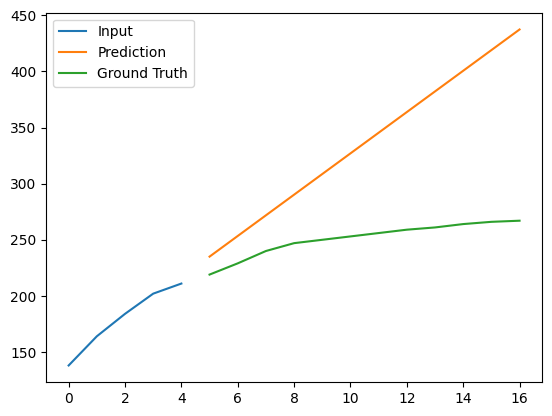

In [14]:
# Plotting an example of the best hyperparameter combination
X = X_test[0]
y = y_test[0]

degree = best_degree
last_n = best_last_n

last = X[-last_n:]
input_size = last_n

reg = LinearRegression().fit(np.arange(0,input_size,1).reshape(input_size,1), last)
preds = reg.predict(np.arange(input_size,input_size+pred_horizon,1).reshape(pred_horizon,1))

plt.plot(np.arange(0,input_size,1), last, label="Input")
plt.plot(np.arange(input_size,input_size+pred_horizon,1), preds, label="Prediction")
plt.plot(np.arange(input_size,input_size+pred_horizon,1), y, label="Ground Truth")
plt.legend()
plt.show()


### Hyperparameter Tuning
* learning rate
* number of iterations
* last n of samples to use for prediction
* order of polynomial (1-5)

# ARIMA Model

In [ ]:
# arima imports
import pmdarima as pm
from pmdarima import model_selection, pipeline ,arima, metrics
from pmdarima import preprocessing as ppc